In [29]:
# SCRIPT SETUP AND LIBRARY IMPORTS


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# Note: "requests" and "datetime" were imported but not used, so they were removed for cleaner code.

# Configure global plot settings for consistency throughout the notebook.
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (16, 8)

print("Setup complete. Libraries imported and plot styles set.")

Setup complete. Libraries imported and plot styles set.


In [30]:
# 1. DATA LOADING


try:
    # Attempt to load the dataset from a local JSON file.
    df_raw = pd.read_json("csgo_skins.json")
    print("Successfully loaded 'csgo_skins.json' ")
    print(f"Found {len(df_raw)} raw data entries")
    
except FileNotFoundError:
    # Handle the case where the file is not found to prevent the script from crashing.
    print("ERROR: The file 'csgo_skins.json' was not found in the same directory.")
    df_raw = pd.DataFrame()



Successfully loaded 'csgo_skins.json' 
Found 2013 raw data entries


In [31]:
# 2. DATA TRANSFORMATION AND CLEANING


# Proceed with transformation only if the data was loaded successfully.
if not df_raw.empty:

    
    # Initialize a new, clean DataFrame to store the structured data.
    df_csgo = pd.DataFrame()

    
    # --- Flatten the nested JSON structure into distinct columns ---
    # Safely extract values from nested dictionaries or lists. Using a lambda function
    # with checks prevents errors if the expected structure (e.g., a dictionary) is missing.

    df_csgo["skin"] = df_raw["name"]
    df_csgo["weapon"] = df_raw["weapon"].apply(lambda x: x["name"] if isinstance(x, dict) else None)
    df_csgo["quality"] = df_raw["rarity"].apply(lambda x: x["name"] if isinstance(x, dict) else None)
    df_csgo["collection"] = df_raw["collections"].apply(lambda x: x[0]["name"] if isinstance(x, list) and x else None)
    df_csgo["crate"] = df_raw["crates"].apply(lambda x: x[0]["name"] if isinstance(x, list) and x else None)
    df_csgo["category"] = df_raw["category"].apply(lambda x: x["name"] if isinstance(x, dict) else "Unknown")

    
    print("\nDataFrame structure after transformation:")
    df_csgo.info()

    
else:
    # If loading failed, create an empty DataFrame with the correct columns to allow
    # the rest of the script to run without errors.
    print("\nSkipping data transformation as the source file was not loaded.")
    df_csgo = pd.DataFrame(columns=["skin", "weapon", "quality", "collection", "crate", "category"])





DataFrame structure after transformation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   skin        2013 non-null   object
 1   weapon      2013 non-null   object
 2   quality     2013 non-null   object
 3   collection  1364 non-null   object
 4   crate       1626 non-null   object
 5   category    2013 non-null   object
dtypes: object(6)
memory usage: 94.5+ KB


In [32]:
# 3.  VISUALIZATION with HEATMAP



def plot_weapon_quality_heatmap(dataframe: pd.DataFrame, title: str, save_filename: str = None):
    """
    Generates and saves a heatmap of item distribution across quality tiers.
    
    Args:
        dataframe (pd.DataFrame): DataFrame with "weapon" and "quality" columns.
        title (str): The title for the heatmap chart.
        save_filename (str, optional): File path to save the plot. If None, it is not saved.
    """
    
    if dataframe.empty:
        print(f"--> Skipping heatmap {title}", "The provided DataFrame is empty.")
        return

    # Create a cross-tabulation to count items per weapon and quality.
    heatmap_data = pd.crosstab(dataframe["weapon"], dataframe["quality"])

    
    # Define a logical order for rarities to sort the heatmap columns correctly.
    RARITY_ORDER = [
        "Consumer Grade", "Industrial Grade", "Mil-Spec", "Restricted", 
        "Classified", "Covert", "Contraband", "Extraordinary"
    ]

    
    # Filter to include only rarities that exist in the current data slice.
    existing_rarities = [rarity for rarity in RARITY_ORDER if rarity in heatmap_data.columns]

    
    if not existing_rarities:
        print(f"--> Skipping heatmap {title}", "Error: unknown Rarities")
        return

    
    # Reorder columns and filter out rows with no relevant items.
    heatmap_data = heatmap_data[existing_rarities]
    heatmap_data = heatmap_data[heatmap_data.sum(axis=1) > 0]

    if heatmap_data.empty:
        print(f"--> Skipping heatmap {title}", "Error: no items remained after filtering")
        return

    
    #Dynamic Figure Size Calculation
    num_rows, num_cols = heatmap_data.shape

    
    # Constants for size calculation (values are from the original script).
    WIDTH_PER_COLUMN = 0.75
    HEIGHT_PER_ROW = 0.5

    
    # Calculate figure size based on data dimensions.
    fig_width = num_cols * WIDTH_PER_COLUMN + 2
    fig_height = num_rows * HEIGHT_PER_ROW + 2

    
    # Cap the figure size to prevent plots from becoming excessively large.
    fig_width = min(fig_width, 14)
    fig_height = min(fig_height, 12)
    
    print(f"--- Creating Heatmap: {title} (Dynamic Size: {round(fig_width,1)}\" x {round(fig_height,1)}\") ---")
    
    plt.figure(figsize=(fig_width, fig_height))
    
    sns.heatmap(
        heatmap_data, 
        annot=True, fmt="d", cmap="rocket_r", linewidths=.5
    )

    #Layout
    plt.title(title, fontsize=20, pad=20)
    plt.xlabel("Quality Tier", fontsize=16) # Changed from German
    plt.ylabel("Item", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    
    #for saving as file
    if save_filename:
        try:
            plt.savefig(save_filename, dpi=300, bbox_inches="tight")
            print(f"--> Heatmap successfully saved to '{save_filename}'")
        except Exception as e:
            print(f"--> ERROR: Could not save heatmap to '{save_filename}'. Reason: {e}")
            
    plt.show()




Data has been regrouped for visualization:
 - 419 entries in 'Pistols'
 - 946 entries in 'Main Weapons'
 - 648 entries in 'Knives & Equipment'

--- Creating Heatmap: Heatmap: Pistols & Zeus (Dynamic Size: 6.5" x 7.5") ---
--> Heatmap successfully saved to 'heatmap_pistols.png'


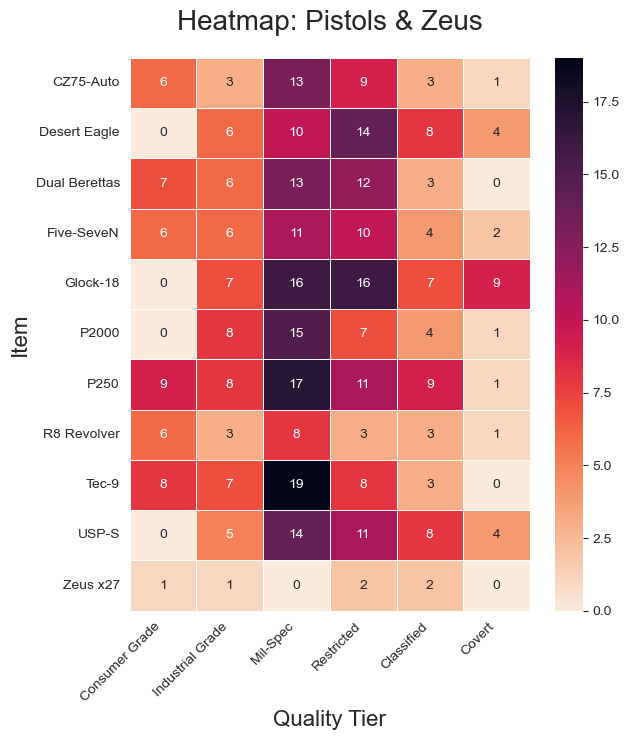

--- Creating Heatmap: Heatmap: Primary Weapons (Rifles, SMGs, etc.) (Dynamic Size: 7.2" x 12") ---
--> Heatmap successfully saved to 'heatmap_main_weapons.png'


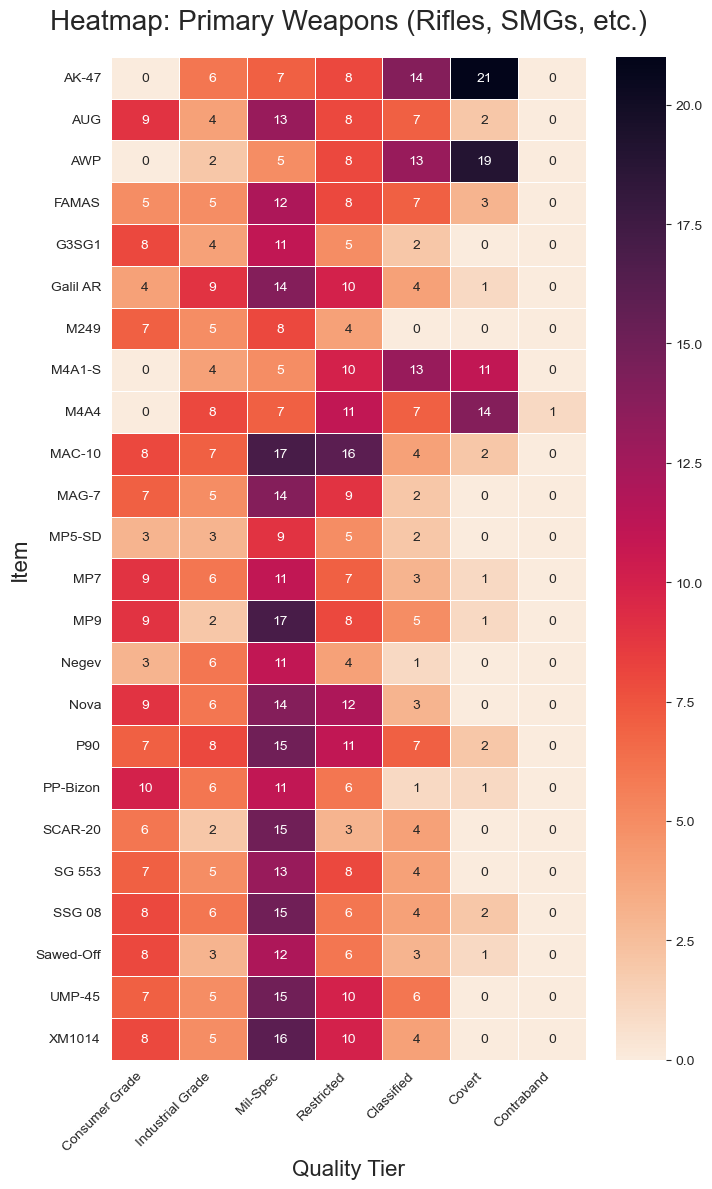

--- Creating Heatmap: Heatmap: Knives & Gloves (Dynamic Size: 3.5" x 12") ---
--> Heatmap successfully saved to 'heatmap_knives_and_equipment.png'


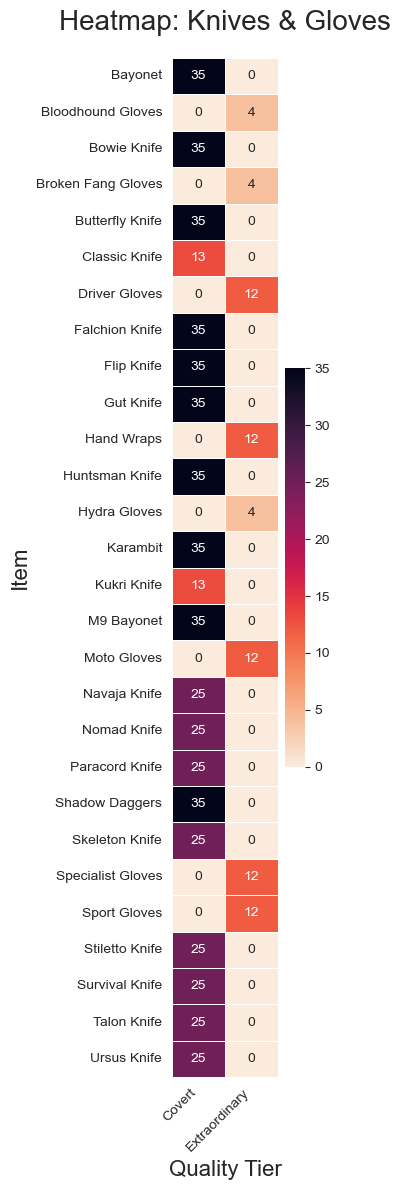

In [33]:

# Prepare data and generate heatmaps for different weapon categories

if not df_csgo.empty:
    
    # Create a copy for visualization to avoid modifying the main DataFrame.
    df_heatmap = df_csgo.copy()

    
    # Standardize quality names and re-categorize a specific weapon.
    df_heatmap["quality"] = df_heatmap["quality"].replace("Mil-Spec Grade", "Mil-Spec")
    df_heatmap.loc[df_heatmap["weapon"] == "Zeus x27", "category"] = "Pistols"

    
    # Define logical groups for the heatmaps.
    pistol_categories = ["Pistols"]
    main_weapon_categories = ["SMGs", "Rifles", "Heavy"]

    
    # Split data into three distinct groups.
    df_pistols = df_heatmap[df_heatmap["category"].isin(pistol_categories)]
    df_main_weapons = df_heatmap[df_heatmap["category"].isin(main_weapon_categories)]
    df_knives_and_equipment = df_heatmap[~df_heatmap["category"].isin(pistol_categories + main_weapon_categories)]

    print("\nData has been regrouped for visualization:")
    print(f" - {len(df_pistols)} entries in 'Pistols'")
    print(f" - {len(df_main_weapons)} entries in 'Main Weapons'")
    print(f" - {len(df_knives_and_equipment)} entries in 'Knives & Equipment'\n")


    
    # Generate a heatmap for each data group.

    #Pistols and Zeus
    plot_weapon_quality_heatmap(
        df_pistols, 
        "Heatmap: Pistols & Zeus", 
        save_filename="heatmap_pistols.png"
    )


    #Main Weapons
    plot_weapon_quality_heatmap(
        df_main_weapons, 
        "Heatmap: Primary Weapons (Rifles, SMGs, etc.)", 
        save_filename="heatmap_main_weapons.png" # Corrected typo from "prime"
    )


    #Knifes & Gloves (Equipment)
    plot_weapon_quality_heatmap(
        df_knives_and_equipment, 
        "Heatmap: Knives & Gloves", 
        save_filename="heatmap_knives_and_equipment.png"
    )

else:
    print("DataFrame 'df_csgo' is empty. Skipping heatmap generation.")